<a href="https://colab.research.google.com/github/Rencode/fastai/blob/main/Is_it_a_bird_Creating_a_model_from_your_own_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Is it a bird?

In [ ]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.


In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

![image.png](attachment:a0483178-c30e-4fdd-b2c2-349e130ab260.png)

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "bird photos"
1. Use DuckDuckGo to search for images of "forest photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a bird and see if it works.

## Step 1: Download images of birds and non-birds

In [ ]:
!pip install -Uqq bs4

In [ ]:
import requests
from bs4 import BeautifulSoup

def get_search_results(search_term):
    url = f"https://unsplash.com/s/photos/{search_term}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }  # Spoofing user agent to avoid bot detection

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        images = soup.find_all('img')
        image_urls = [img['src'] for img in images]
        return image_urls
    else:
        print("Failed to fetch search results")
        return []

# Example usage
query = "cats"
image_urls = get_search_results(query)
print(f'number of images {len(image_urls)}')
for url in image_urls:
    print(url)

number of images 175
https://media.istockphoto.com/id/1498838344/photo/grumpy-persian-waiting-on-food.webp?b=1&s=170667a&w=0&k=20&c=LjAK_5FedDnEnip4MwdaV32Jbp9aNix0VRk2Lb4uaag=
https://media.istockphoto.com/id/1487283582/photo/silver-tabby-cat-peeks-out-from-behind-a-white-wall.webp?b=1&s=170667a&w=0&k=20&c=JTxBT8h-xp0ByPKS9doMNrS2j4M6jYmjcnyrdzrMqt4=
https://media.istockphoto.com/id/1443328418/photo/tabby-cat-closeup-portrait.webp?b=1&s=170667a&w=0&k=20&c=ZPpQHOnRDGqB1XsuCb8aIp4_mxxuBwhhZfAhCN91S1w=
https://media.istockphoto.com/id/1613987510/photo/laziness.webp?b=1&s=170667a&w=0&k=20&c=_CmvzaFXIIsMjT5dovxSPW1YkB2ieVzHyfdjaIK8YLQ=
https://media.istockphoto.com/id/1443562748/photo/cute-ginger-cat.webp?b=1&s=170667a&w=0&k=20&c=2EV5yXpZ5o3govOwB8EHPcD1xeYawBMdjmtX7pkjcCU=
https://media.istockphoto.com/id/1494242978/photo/cat-stands-on-its-hind-legs-with-its-front-paws-raised.webp?b=1&s=170667a&w=0&k=20&c=hJA0GdGHp-lcQgPvR1qZw16RAtgiXe1C55yec0QlBBE=
https://media.istockphoto.com/id/143957

In [ ]:
import httpx
import json

def get_images(keywords, max_results=None):
    url = f"https://duckduckgo.com/?va=f&t=hg&q={keywords}&iax=images&ia=images"
    headers = {
        "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
        "accept-language": "en-US,en;q=0.9,hi;q=0.8",
        "cache-control": "max-age=0",
        "sec-ch-ua": "\"Google Chrome\";v=\"113\", \"Chromium\";v=\"113\", \"Not-A.Brand\";v=\"24\"",
        "sec-ch-ua-mobile": "?0",
        "sec-ch-ua-platform": "\"Windows\"",
        "sec-fetch-dest": "document",
        "sec-fetch-mode": "navigate",
        "sec-fetch-site": "same-origin",
        "sec-fetch-user": "?1",
        "sec-gpc": "1",
        "upgrade-insecure-requests": "1",
        "cookie": "p=-2; ah=in-en; l=in-en",
        "Referer": "https://duckduckgo.com/",
        "Referrer-Policy": "origin"
    }

    with httpx.Client() as client:
        response = client.get(url, headers=headers)

    #print("Response status code:", response.status_code)
    resp = response.text

    vqd_index_start = resp.index('vqd="') + 5
    vqd_index_end = resp.index('"', vqd_index_start)
    vqd_bytes = resp[vqd_index_start:vqd_index_end]
    #print(f"vqd_bytes: {vqd_bytes}")

    images_url = f"https://duckduckgo.com/i.js?o=json&q={keywords}&vqd={vqd_bytes}"

    with httpx.Client() as client:
        response = client.get(images_url, headers=headers)

    #print("Response status code:", response.status_code)
    # with open("F://Python//playground//temp.json", "w") as f:
    #     json.dump(response.json(), f)

    response = response.json()
    #response["results"] =
    results = response["results"][:max_results] if max_results else response["results"]
    return [res['image'] for res in results]

In [ ]:
urls = get_images('bird photos', max_results=1)
print(urls)

Response status code: 200
vqd_bytes: 4-118385833662995198309312565679363829059
Response status code: 200
['https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg']


In [ ]:
list(results)

HTTPStatusError: Client error '403 Forbidden' for url 'https://duckduckgo.com/i.js?l=wt-wt&o=json&s=0&q=bird%20photo&vqd=4-258110933598418681310326809844719896143&f=%2C%2C%2C%2C%2C&p=1'
For more information check: https://httpstatuses.com/403

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

...and then download a URL and take a look at it:

Response status code: 200
vqd_bytes: 4-257498948893446655640467707711052382994
Response status code: 200


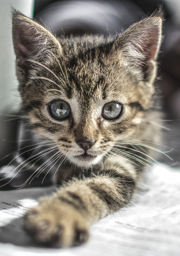

In [ ]:
from fastdownload import download_url
dest = 'cat.jpg'
download_url(get_images('cat photo', max_results=1)[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Response status code: 200
vqd_bytes: 4-250600797937342738945777382004044656845
Response status code: 200


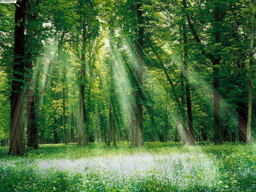

In [ ]:
download_url(get_images('forest photos', max_results=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [ ]:
cat_urls = image_urls

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "bird" and "forest" photos, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [ ]:
searches = 'forest','cat'
path = Path('cat_or_not_2')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=get_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=get_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=get_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:1018: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")
/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

In [ ]:
len(Path('cat_or_not_2/forest').ls())

121

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

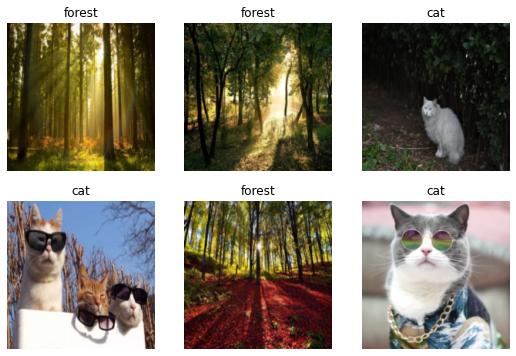

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
#!pip3 install --upgrade fastai
from fastai.vision import learner
from fastcore.all import *
#print(dir(learner))
#from fastai.vision.learner import vision_learner
learn = learner.cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.768616,0.838843,0.212766,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.097051,0.135396,0.042553,00:01
1,0.079817,0.179644,0.021277,00:01
2,0.059458,0.184607,0.021277,00:01


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
is_cat,_,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[0]:.4f}")

This is a: cat.
Probability it's a cat: 0.9993


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.